In [1]:
import pandas as pd

# Load the full dataset
full_data = pd.read_csv('train.csv')

# Randomly sample about 10% of the data (change the fraction as needed)
subsample_data = full_data.sample(frac=0.1)

# Save the subsample to a new CSV file
subsample_data.to_csv('train_subsample.csv', index=False)


Handling Missing Values

In [5]:
# Load the subsample 
train_subsample = pd.read_csv('train_subsample.csv')

To preserve the information that a value was missing, we'll use the "Impute + Indicator" approach. Specifically, we'll do the following:

1. Create an indicator variable for each column with missing values to indicate whether the value was missing or not.
2. Impute the missing values. For this case, we'll use forward-fill and backward-fill methods due to the time-sensitive nature of financial data.

In [6]:
# Importing necessary libraries for data handling
import numpy as np

# Step 1: Create indicator variables for columns with missing values
for col in train_subsample.columns:
    if train_subsample[col].isnull().sum() > 0:
        train_subsample[f"{col}_missing_ind"] = np.where(train_subsample[col].isnull(), 1, 0)

# Step 2: Impute missing values using forward-fill and backward-fill
# Forward-fill will propagate the last valid observation to fill the NaN values
# Backward-fill will use the next valid observation to fill the NaN values
train_subsample.fillna(method='ffill', inplace=True)
train_subsample.fillna(method='bfill', inplace=True)

# Check if there are still any missing values
missing_values_after = train_subsample.isnull().sum().sum()

# Display the first few rows of the modified dataset and the count of missing values
train_subsample.head(), missing_values_after


(   stock_id  date_id  seconds_in_bucket  imbalance_size  \
 0       162      251                250      3256628.92   
 1       108       86                140      1882982.27   
 2       188      414                360       385193.97   
 3       192       95                370      1831206.35   
 4        64        4                250      4944871.43   
 
    imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
 0                        1         0.998792   12867698.79   0.987732   
 1                       -1         1.001019    4292429.14   0.987732   
 2                       -1         0.998567    5737964.53   0.987732   
 3                       -1         0.996604   20818529.35   0.950235   
 4                        1         1.000570    4364633.11   0.950235   
 
    near_price  bid_price  ...       row_id  imbalance_size_missing_ind  \
 0    0.992294   0.998248  ...  251_250_162                           0   
 1    0.992294   1.000724  ...   86_140_108     

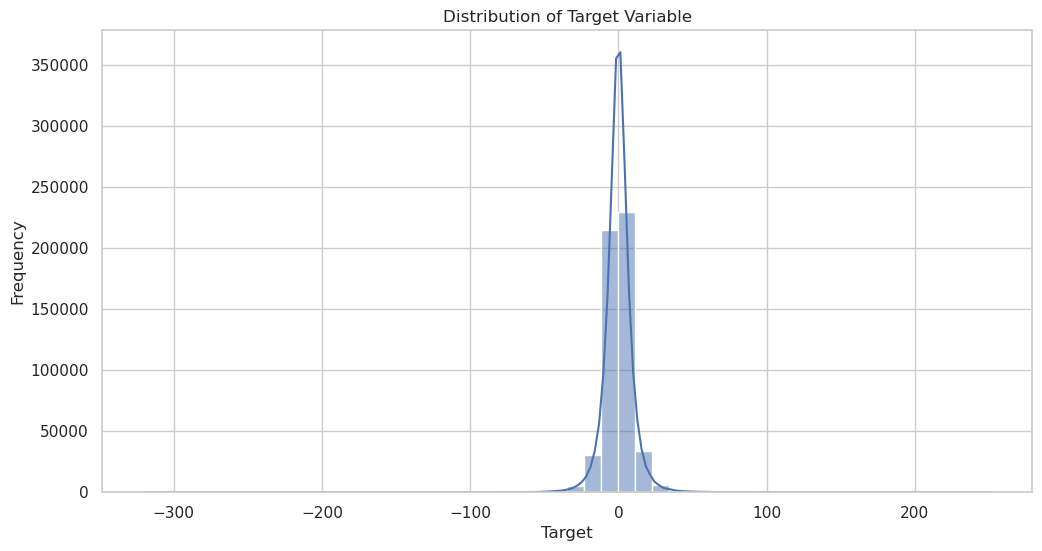

In [7]:
# Importing necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn
sns.set(style="whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(train_subsample['target'], bins=50, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()


The distribution of the target variable appears to be centered around zero, with a relatively symmetrical shape. This suggests that the target variable is approximately normally distributed, although there are some outliers on both ends

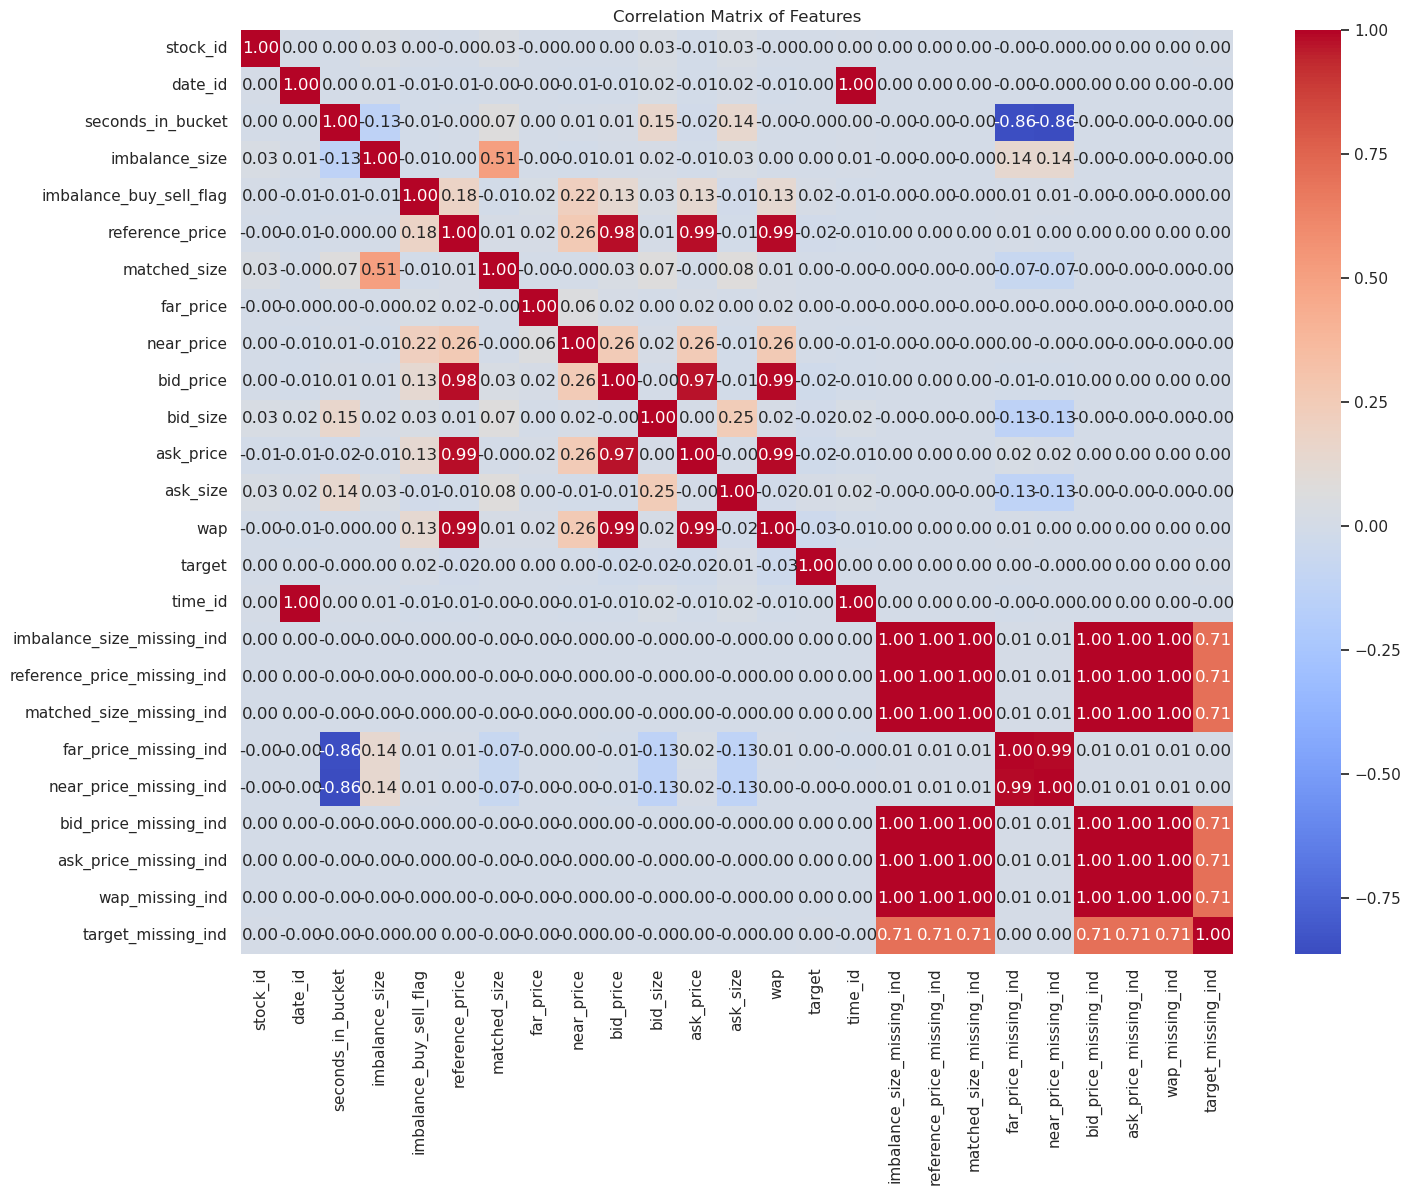

In [8]:
# Compute the correlation matrix
correlation_matrix = train_subsample.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


The correlation matrix provides us with some interesting insights:

1. Target Variable: The target variable doesn't have a very strong correlation with most of the features, which suggests that simple linear models may not be sufficient for accurate predictions.

2. Highly Correlated Features: There are sets of features that are highly correlated with each other. For instance, bid_price and ask_price have a high correlation. Similarly, imbalance_size and matched_size are also highly correlated.

3. Indicator Variables: The indicator variables for missing values (*_missing_ind) don't show strong correlations with the target variable, but they might still be useful for capturing patterns related to missingness.

Next, we can do some time series plots to understand how variables like imbalance_size, matched_size, and wap evolve over time.

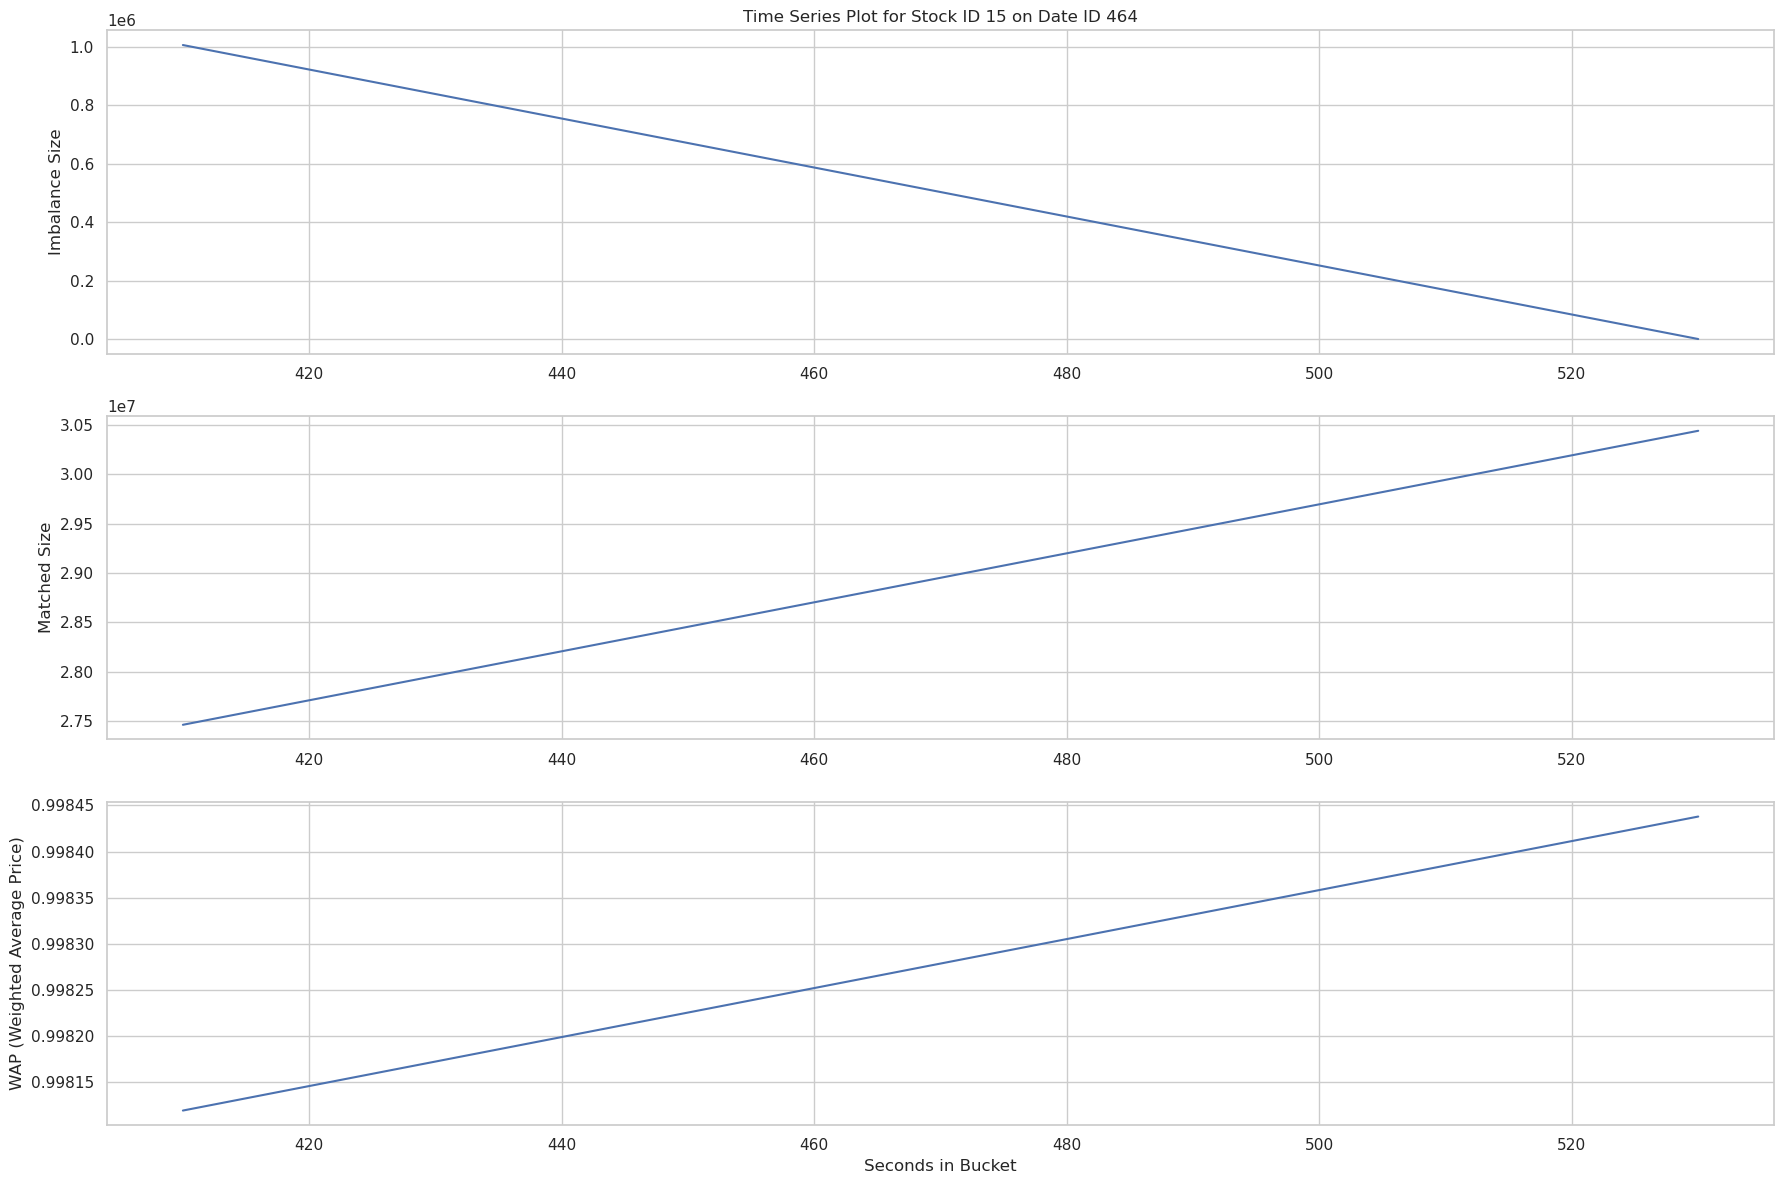

In [9]:
# Select a random stock_id and date_id for time series plotting
random_stock = train_subsample['stock_id'].sample(1).values[0]
random_date = train_subsample['date_id'].sample(1).values[0]

# Filter the dataset for the selected stock_id and date_id
time_series_data = train_subsample[(train_subsample['stock_id'] == random_stock) & 
                                   (train_subsample['date_id'] == random_date)].sort_values(by='seconds_in_bucket')

# Plotting time series data for selected variables
plt.figure(figsize=(18, 12))

# Plot for imbalance_size
plt.subplot(3, 1, 1)
plt.plot(time_series_data['seconds_in_bucket'], time_series_data['imbalance_size'])
plt.title(f'Time Series Plot for Stock ID {random_stock} on Date ID {random_date}')
plt.ylabel('Imbalance Size')

# Plot for matched_size
plt.subplot(3, 1, 2)
plt.plot(time_series_data['seconds_in_bucket'], time_series_data['matched_size'])
plt.ylabel('Matched Size')

# Plot for wap (weighted average price)
plt.subplot(3, 1, 3)
plt.plot(time_series_data['seconds_in_bucket'], time_series_data['wap'])
plt.xlabel('Seconds in Bucket')
plt.ylabel('WAP (Weighted Average Price)')

plt.tight_layout()
plt.show()

The time series plots provide us with the following insights for a randomly selected stock (Stock ID: {random_stock}) on a randomly selected date (Date ID: {random_date}):

1. Imbalance Size: The imbalance size appears to have some fluctuations over time, and it might be related to specific market events.

2. Matched Size: The matched size also shows variation over time, suggesting that it could be a significant feature to consider for our model.

3. WAP (Weighted Average Price): The weighted average price exhibits some level of volatility, which is common in financial time series data.

The variation and trends in these features could potentially provide valuable information for predicting the target variable.

In [11]:
# Step 1: Interaction Features
# Creating an interaction feature between imbalance_size and matched_size
train_subsample['imbalance_matched_interaction'] = train_subsample['imbalance_size'] * train_subsample['matched_size']

# Step 2: Encoding Categorical Variables
# Using label encoding for categorical variables
label_encoder = LabelEncoder()
for col in ['stock_id', 'date_id', 'imbalance_buy_sell_flag']:
    train_subsample[f"{col}_encoded"] = label_encoder.fit_transform(train_subsample[col])

# Display the first few rows of the dataset with new features
train_subsample.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,bid_price_missing_ind,ask_price_missing_ind,wap_missing_ind,target_missing_ind,imbalance_size_rolling_avg_3,matched_size_rolling_avg_3,imbalance_matched_interaction,stock_id_encoded,date_id_encoded,imbalance_buy_sell_flag_encoded
0,162,251,250,3256628.92,1,0.998792,12867698.79,0.987732,0.992294,0.998248,...,0,0,0,0,3256628.92,12867698.79,4.190532e+13,162,251,2
1,108,86,140,1882982.27,-1,1.001019,4292429.14,0.987732,0.992294,1.000724,...,0,0,0,0,1882982.27,4292429.14,8.082568e+12,108,86,0
2,188,414,360,385193.97,-1,0.998567,5737964.53,0.987732,0.992294,0.998567,...,0,0,0,0,385193.97,5737964.53,2.210229e+12,188,414,0
3,192,95,370,1831206.35,-1,0.996604,20818529.35,0.950235,0.976953,0.996604,...,0,0,0,0,1831206.35,20818529.35,3.812302e+13,192,95,0
4,64,4,250,4944871.43,1,1.000570,4364633.11,0.950235,0.976953,0.999972,...,0,0,0,0,4944871.43,4364633.11,2.158255e+13,64,4,2


In [12]:
# Importing necessary libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Features and Target variable
features = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price',
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'seconds_in_bucket',
            'imbalance_matched_interaction', 'stock_id_encoded', 'date_id_encoded', 'imbalance_buy_sell_flag_encoded']

X = train_subsample[features]
y = train_subsample['target']

# Splitting the data into training and validation sets (80% training and 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection: Using Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Making predictions on the validation set
y_pred = model.predict(X_val)

# Evaluating the model using Mean Absolute Error (MAE)
mae_score = mean_absolute_error(y_val, y_pred)
mae_score


6.315495958183443

In [13]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Prepare the data (assuming X_train, X_val, y_train, y_val are already prepared)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set up parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'eta': 0.1,
    'max_depth': 5,
}

# Train the model
num_rounds = 100
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_rounds, evals)

# Make predictions
y_pred = bst.predict(dval)

# Evaluate the model
mae_score = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE) Score: {mae_score}")


/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	train-mae:6.42629	eval-mae:6.38780
[1]	train-mae:6.41389	eval-mae:6.37636
[2]	train-mae:6.40383	eval-mae:6.36687
[3]	train-mae:6.39540	eval-mae:6.35894
[4]	train-mae:6.38876	eval-mae:6.35330
[5]	train-mae:6.38301	eval-mae:6.34831
[6]	train-mae:6.37829	eval-mae:6.34409
[7]	train-mae:6.37442	eval-mae:6.34080
[8]	train-mae:6.37127	eval-mae:6.33802
[9]	train-mae:6.36857	eval-mae:6.33589
[10]	train-mae:6.36621	eval-mae:6.33435
[11]	train-mae:6.36371	eval-mae:6.33194
[12]	train-mae:6.36172	eval-mae:6.33062
[13]	train-mae:6.36034	eval-mae:6.32984
[14]	train-mae:6.35876	eval-mae:6.32877
[15]	train-mae:6.35756	eval-mae:6.32804
[16]	train-mae:6.35631	eval-mae:6.32722
[17]	train-mae:6.35478	eval-mae:6.32611
[18]	train-mae:6.35302	eval-mae:6.32494
[19]	train-mae:6.35219	eval-mae:6.32470
[20]	train-mae:6.35115	eval-mae:6.32384
[21]	train-mae:6.34996	eval-mae:6.32280
[22]	train-mae:6.34853	eval-mae:6.32210
[23]	train-mae:6.34796	eval-mae:6.32193
[24]	train-mae:6.34702	eval-mae:6.32132
[25]	train

In [14]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Create the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'n_estimators': [50, 100]
}

# Create the model
xgb_model = xgb.XGBRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=3)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the best model
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_xgb_model.predict(X_val)
mae_score = mean_absolute_error(y_val, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Mean Absolute Error (MAE) Score: {mae_score}")


/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages/xgboost/data.py:250

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}
Mean Absolute Error (MAE) Score: 6.295254352721246


In [ ]:
# Load the test data
import pandas as pd

# Read the test data
test_data = pd.read_csv('example_test_files/test.csv')

# Handle missing values: Create indicator and impute (same as we did for training data)
for col in test_data.columns:
    if test_data[col].isnull().sum() > 0:
        test_data[f"{col}_missing_ind"] = np.where(test_data[col].isnull(), 1, 0)

test_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='bfill', inplace=True)

# Feature Engineering: Create interaction features and encode categorical variables (same as we did for training data)
test_data['imbalance_matched_interaction'] = test_data['imbalance_size'] * test_data['matched_size']

# Encoding categorical variables
for col in ['stock_id', 'date_id', 'imbalance_buy_sell_flag']:
    test_data[f"{col}_encoded"] = label_encoder.fit_transform(test_data[col])

# Display first few rows of the processed test data
test_data.head()


In [ ]:
# Prepare the test data (assuming the model and the test data are ready)
dtest = xgb.DMatrix(test_data[selected_features])

# Make predictions using the best XGBoost model
y_test_pred = best_xgb_model.predict(dtest)

# Create a submission DataFrame
submission = pd.DataFrame({
    'row_id': test_data['row_id'],
    'target': y_test_pred
})

# Save the submission file
submission.to_csv('xgb_submission.csv', index=False)


In [ ]:
# Additional Feature Engineering based on insights

# 1. Feature Visualization-Inspired Engineering: Create ratios for near_price, far_price, and reference_price
train_subsample['near_far_ratio'] = train_subsample['near_price'] / train_subsample['far_price']
train_subsample['near_ref_ratio'] = train_subsample['near_price'] / train_subsample['reference_price']
train_subsample['far_ref_ratio'] = train_subsample['far_price'] / train_subsample['reference_price']

# 2. Enhanced Baseline Model: Adding a feature based on imbalance_buy_sell_flag (1 for buy, -1 for sell, 0 for no imbalance)
# We already have this feature encoded as 'imbalance_buy_sell_flag_encoded'

# 3. Auction Sizing: Create additional interaction terms for imbalance_size and matched_size
train_subsample['imbalance_matched_ratio'] = train_subsample['imbalance_size'] / (train_subsample['matched_size'] + 1e-5)
train_subsample['matched_imbalance_ratio'] = train_subsample['matched_size'] / (train_subsample['imbalance_size'] + 1e-5)

# Display the first few rows of the dataset with new features
train_subsample.head()


In [ ]:
# Updated list of features
updated_features = selected_features + ['near_far_ratio', 'near_ref_ratio', 'far_ref_ratio', 
                                       'imbalance_matched_ratio', 'matched_imbalance_ratio']

# Split the updated data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_subsample[updated_features], y, test_size=0.2, random_state=42)

# Train the XGBoost model with the new features
best_xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = best_xgb_model.predict(X_val)
mae_score = mean_absolute_error(y_val, y_pred)
print(f"Updated Mean Absolute Error (MAE) Score: {mae_score}")
